# Using Unsupervised Learning to plan Paris Vacation - clustering

In [1]:
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

try:
    import contextily as cx
except ImportError as error:
    !pip install contextily==1.2.0;
    import contextily as cx


!pip install haversine
import haversine as hs

from sklearn.cluster import BisectingKMeans # Importing KMeans

import folium

try:
    import networkx as nx
except ImportError as error:
    !pip install networkx;
    import networkx as nx
import networkx.algorithms.approximation as nx_app

sns.set_theme()

In [2]:
df_coord = pd.read_csv('../neo4j/import/poi.csv')

df_coord

,id,name,latitude,longitude,address,locality,class
0,909553,Le Quincangrogne,48.883487,2.736122,7 rue de l'Abreuvoir\n77400 Dampmart,Dampmart,['Restaurant']
1,5506379,Puces de Paris - Saint-Ouen,48.904075,2.338965,Rue des Rosiers\n93400 Saint-Ouen-sur-Seine,Saint-Ouen-sur-Seine,['CulturalSite']
2,5777859,Marché de Longjumeau - Arcades,48.690141,2.289235,163 rue du Président F. Mitterrand\n91160 Long...,Longjumeau,['EntertainmentAndEvent']
3,727348,Barbizon,48.447193,2.603497,NaN,Barbizon,['CulturalSite']
4,838134,Jardin du musée Zadkine,48.843031,2.333834,100 bis rue d'Assas\n75006 Paris 6e Arrondisse...,Paris 6e Arrondissement,"['ParkAndGarden', 'CulturalSite']"
...,...,...,...,...,...,...,...
1851,4890429,Bibliothèque Henri Cartier-Bresson,48.855058,2.727695,2 route du Moulin Bourcier\n77600 Chanteloup-e...,Chanteloup-en-Brie,['CulturalSite']
1852,801664,Marché du Chaperon Vert,48.811541,2.334354,Marché\n94250 Gentilly,Gentilly,['EntertainmentAndEvent']
1853,4911910,Médiathèque de Saint-Germain-lès-Corbeil,48.621250,2.491466,1 place Victor Hugo\n91250 Saint-Germain-lès-C...,Saint-Germain-lès-Corbeil,['CulturalSite']
1854,705878,Musée Rodin - Meudon,48.813896,2.252615,19 avenue Auguste Rodin\n92190 Meudon,Meudon,"['Museum', 'CulturalSite']"


In [3]:
df_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1856 non-null   int64  
 1   name       1856 non-null   object 
 2   latitude   1856 non-null   float64
 3   longitude  1856 non-null   float64
 4   address    1789 non-null   object 
 5   locality   1856 non-null   object 
 6   class      1856 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 101.6+ KB


## Premières visualisations
### Répartition géographique


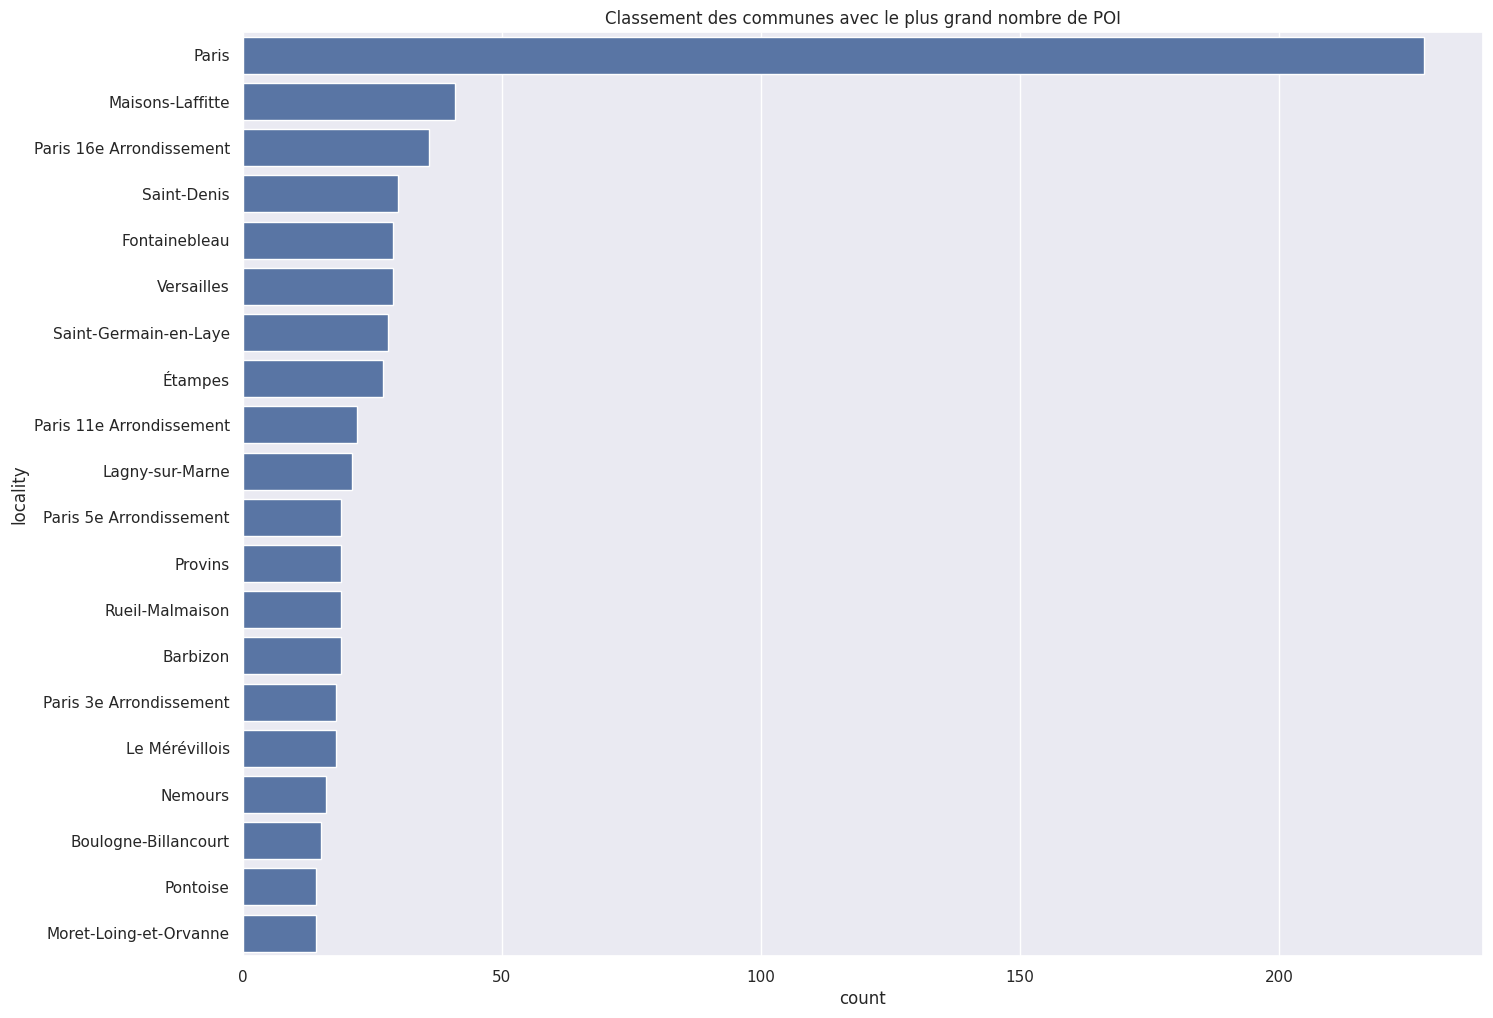

In [4]:
#Confirmation de l'emplacement des POI par commune

sns.set(rc = {'figure.figsize':(16,12)})
sns.countplot(y="locality", color = "b", data = df_coord, order=df_coord.locality.value_counts().iloc[:20].index).set_title('Classement des communes avec le plus grand nombre de POI');

# On choisit les 20 premières communes pour améliorer la lisibilité du graphique
# Les communes avec le plus grand nombre de POI sont bien situées sur la côte, en tête Saint-Malo avec une large longueur d'avanc
# Il va être intéressant par la suite de s'intéresser au détail de ces POI

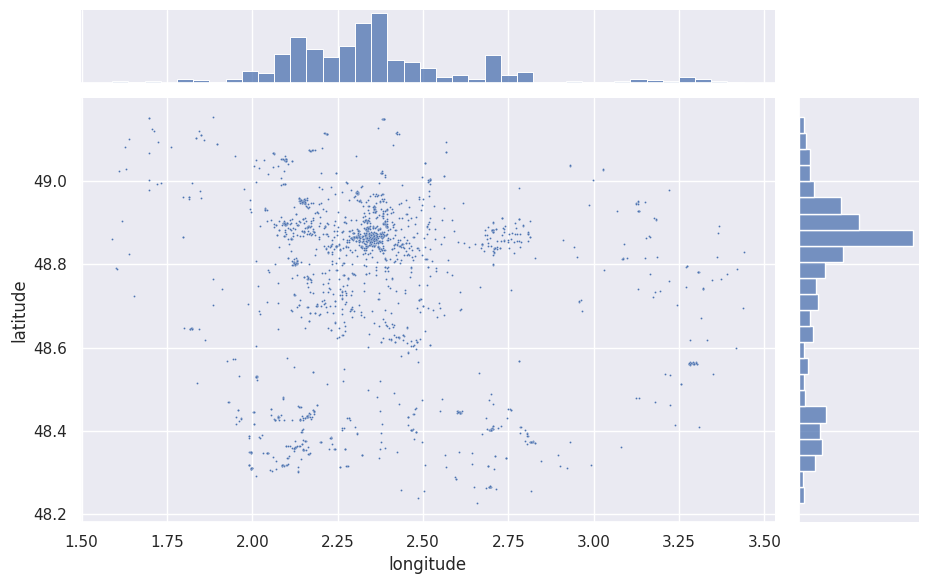

In [5]:
#Répartition des POI en fonction de la latitude et longitude

sns.jointplot(x='longitude', y='latitude', data=df_coord, s=2 ).fig.set_figwidth(10)

# On adapte la taille du jointplot en rectangle pour retrouver +/- la forme de la Bretagne
# On observe par la même occasion qu'il n'y a pas de valeur aberrante, tous les points sont localisés dans une zone géographique cohérente
# On remarque à première vue que la plupart des lieux sont à Paris intra-muros.
# On devine la forme de l'ile de france avec une très forte concentration

In [6]:
import ast
def try_parse_list(s):
    try:
        return ast.literal_eval(s)
    except (ValueError, SyntaxError):
        return None

# nouveau df à exploser
df_class = df_coord[['id', 'latitude', 'longitude', 'class']].copy()
df_class['class'] = df_class['class'].apply(try_parse_list)
df_class = df_class.explode('class')

df_class.head()

# on crée le df pour afficher les 10 premières classes
class_counts = df_class['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']
class_counts = class_counts.sort_values(by='count', ascending=False).head(10)

print(class_counts)

                           class  count
0                   CulturalSite   1109
1          EntertainmentAndEvent    327
2                  ParkAndGarden    207
3                         Museum    206
4                BistroOrWineBar    144
5                         Church    143
6                     Restaurant    106
7  ArtGalleryOrExhibitionGallery     91
8             RemarkableBuilding     62
9                         Castle     43


Text(0.5, 1.0, 'Répartition des classes')

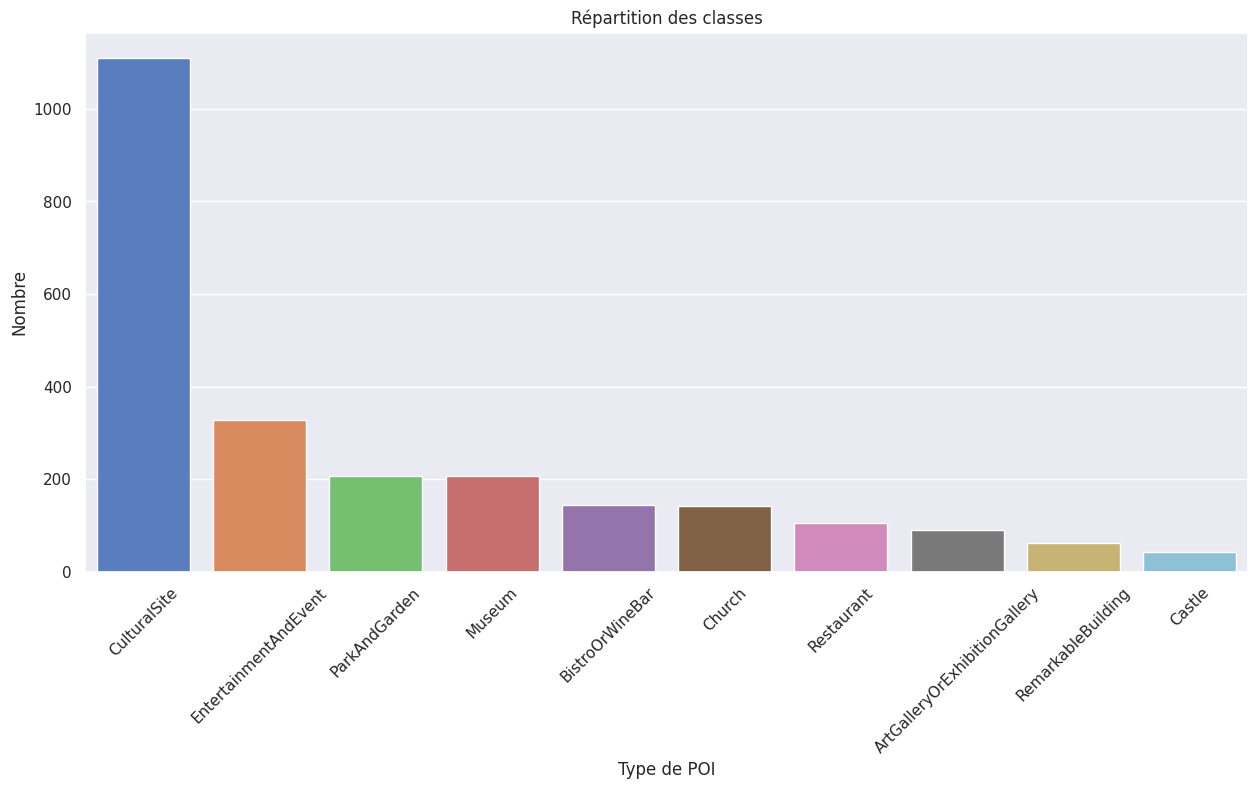

In [7]:
# Graphique de répartition par classes


plt.figure(figsize=(15, 7))
ax = sns.barplot(x='class', y='count', data=class_counts, palette='muted')
ax.set(xlabel='Type de POI', ylabel='Nombre')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Répartition des classes')

RasterioIOError: idf.tif: No such file or directory

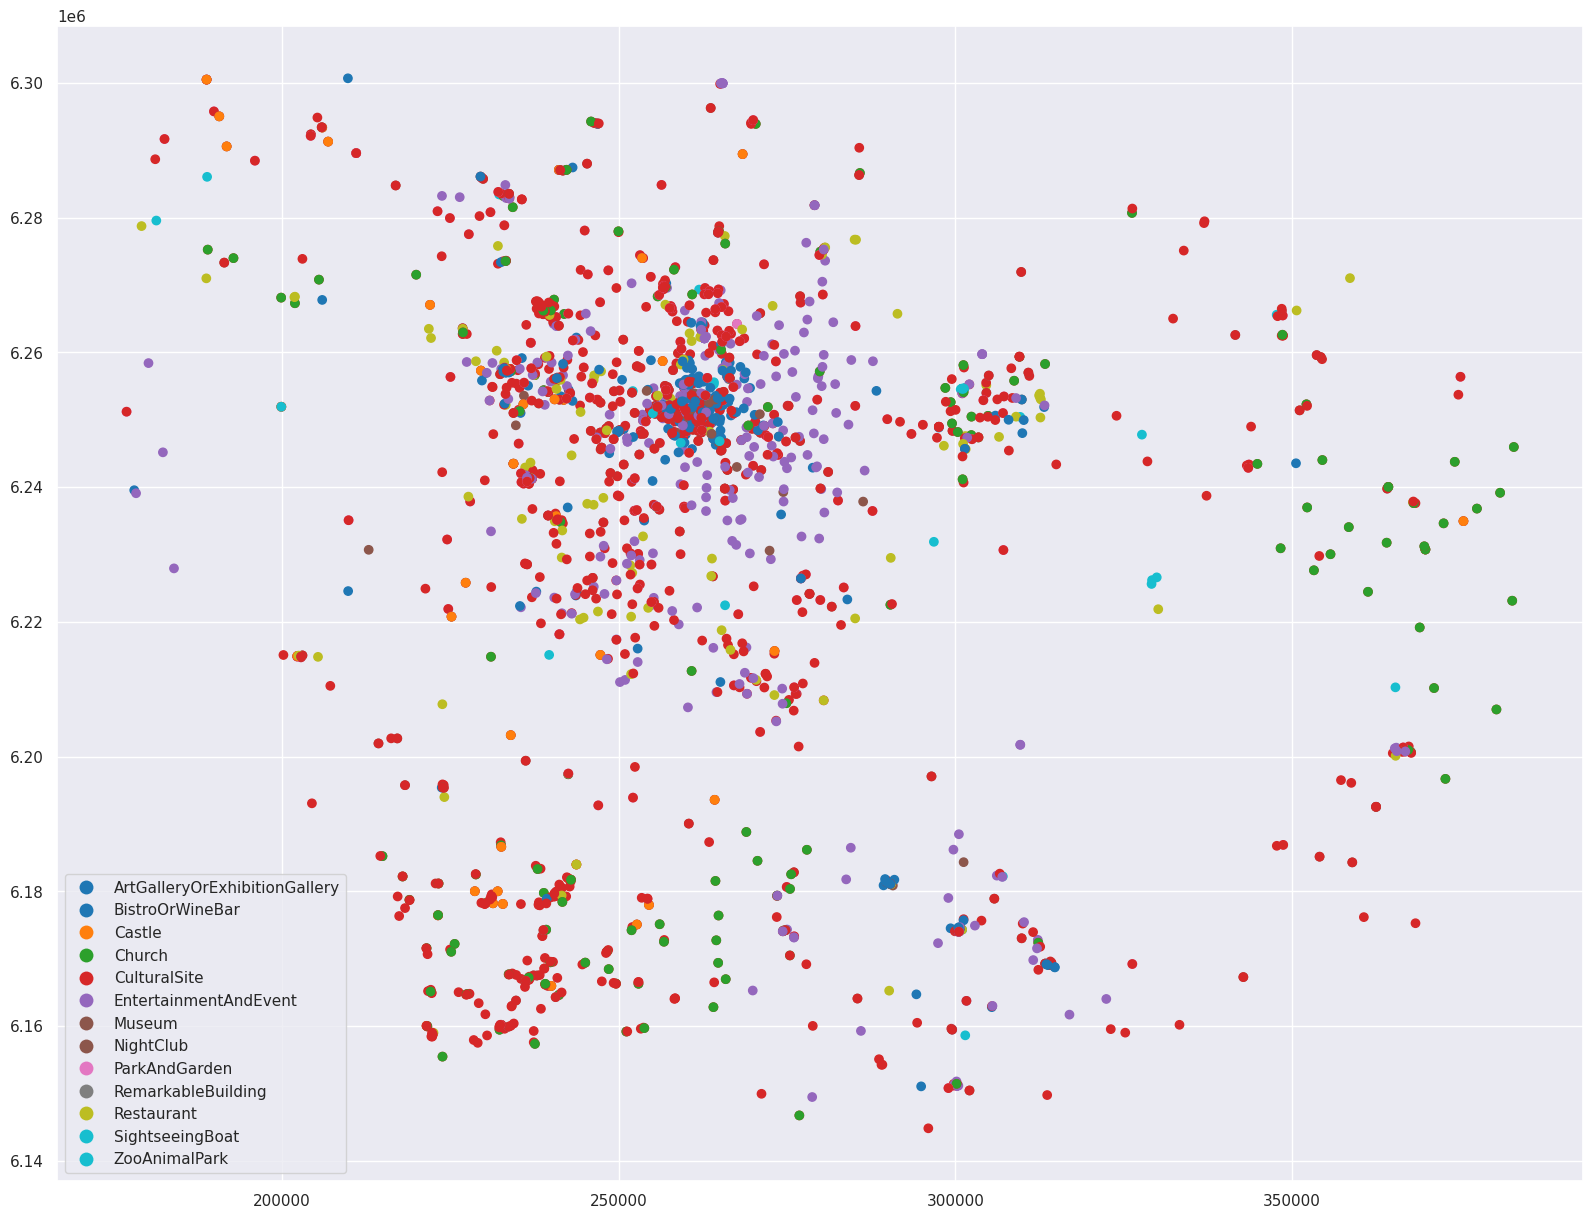

In [8]:
import geopandas
import contextily as cx

# Répartition des catégories de POI
pointoi_gdf = geopandas.GeoDataFrame(df_class, geometry=geopandas.points_from_xy(df_class.longitude, df_class.latitude))

# Conversion des systemes de coordonnées pour etre compatible avec la carte:
pointoi_gdf = pointoi_gdf.set_crs(epsg=4326)
pointoi_gdf = pointoi_gdf.to_crs(epsg=3857)

# Plot sur la carte
ax = pointoi_gdf.plot(column='class', legend=True, figsize=(20,15))
cx.add_basemap(ax, source='idf.tif', zoom=10)
plt.title('Répartition géographique des catégories de POI sur la région Ile de France');


## Modélisation

### Choix utilisateurs


In [9]:
u_start_point = (48.8672391, 2.3210898) # Hotel Crillon place de la Concorde
u_nb_jour = 7
u_moyen_mobilite = "Metro" # Marche/ Velo / Voiture
u_categorie = None
u_nb_pts_max = 8 # temps min de visite 60 minutes sur 8h soit ... 8


### Constantes

In [10]:
#Definition des paramètres d'itinéraires
MAX_TIME_PER_DAY = 480 #8h * 60 min

MAX_KM_BY_TRANSPORT = {
    "Marche": 5, #10 km Aller / Retour
    "Velo": 10, #20 km Aller / Retour
    "Metro": 15, #30 km Aller / Retour
    "Voiture": 60 #120 km Aller / Retour
}

# Gestion de la distance max
nb_km_max = MAX_KM_BY_TRANSPORT[u_moyen_mobilite]

# Couleurs utilisées par folium pour les markers
FOLIUM_COLORS = [
    'red','blue', 'green', 'purple', 'orange', 'darkred',
    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
    'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'
]
# Zoom a appliquer sur la carte
ZOOM_LVL = {
    'Metro': 12,
    'Velo': 15,
    'Marche': 20,
    'Voiture': 10
}

## Fonctions


In [11]:
# Declaration des fonction
def plot_markers(dataframe, map_to_plot, color_palette = FOLIUM_COLORS, icon='star'):
    """
        Plot markers on a foilum map using coord column on a dataframe and a specified color palette
    """
    for _idx, row in dataframe.iterrows():
        color_idx = row["Jour"] - 1
        max_colors_idx = len(color_palette) - 1
        if color_idx > max_colors_idx:
            color_idx = color_idx - max_colors_idx
        color = color_palette[color_idx]
        icon_color = 'dimgray' if color == 'white' else 'white'
        folium.Marker(
            location= list(row.Coord),
            popup= f"<h5>Jour {row['Jour']}</h5><p>{row['name']}</p>",
            icon= folium.Icon(color= color, icon_color= icon_color, icon=icon)
        ).add_to(map_to_plot)

def plot_day_path(dataframe, map_to_plot, color):
    """
        Compute shortest path by creating a graph from coordonates and then plot it on a folium map in. the selected color
    """
    G = nx.Graph()
    nodes = np.arange(0, len(dataframe))
    # nodes -> array([0, 1, 2, 3, 4])
    G.add_nodes_from(nodes)

    for i in nodes:
        for j in nodes:
            if i!=j:
                G.add_edge(i, j)

    #Create a dictionary of node and coordinate of each state for positions
    positions = {node:coordinate for node, coordinate in zip(nodes, dataframe.Coord)}

    #Create a dictionary of node and capital for labels
    labels = {node:name for node, name in zip(nodes, dataframe['name'])}

    cycle = nx_app.christofides(G, weight="weight")

    folium_coordinates = []
    for lat,lon in dataframe.Coord:
        folium_coordinates.append([lat,lon])

    route = [] # u_start_point
    for stop in cycle:
        route.append(folium_coordinates[stop])
    folium.PolyLine(route, color = color, weigth = 0.5).add_to(map_to_plot)

def result_df(result):
    return pd.DataFrame(result['Jour'].value_counts().sort_index()).rename(columns= {'Jour': 'nombre POI'})


### Application des paramètres utilisateurs à l'ensemble de points


In [12]:
def     get_user_radius_df():
    app_df = df_coord.copy()

    #Ensemble des coordonnées
    app_df["Coord"] = list(zip(app_df["latitude"], app_df["longitude"])) # Coord tupples

    # Calcul de la distance au point de départ
    app_df["Distance_start_point"] = app_df["Coord"].apply(lambda point: hs.haversine(u_start_point, point))

    # Conservation des points dans le rayon du point de départ du voyageur
    return app_df[app_df["Distance_start_point"] <= nb_km_max].copy()


# NOTE: https://geopandas.org/en/stable/docs/user_guide/geometric_manipulations.html#GeoSeries.buffer
# aurait pu etre une option


### Carte points par jour


In [13]:
### KMeans solo
from sklearn.cluster import KMeans

kmeans_1 = KMeans(n_clusters=u_nb_jour, random_state=123)
kmean_places_to_visit = get_user_radius_df()

X = kmean_places_to_visit[['latitude','longitude']].values
predictions = kmeans_1.fit_predict(X)
clustered = pd.concat([kmean_places_to_visit.reset_index(),
                       pd.DataFrame({'Cluster':predictions})],
                      axis=1)

clustered["Jour"] = clustered["Cluster"] + 1

kmeans_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(clustered, map_to_plot=kmeans_map)

kmeans_map

/home/david/miniconda3/envs/itineraire-touristique/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/david/anaconda3/envs/itineraire-touristique/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


distances[knee] :2.499603767447128
knee: 99
0.00039234034136746574


<Figure size 500x500 with 0 Axes>

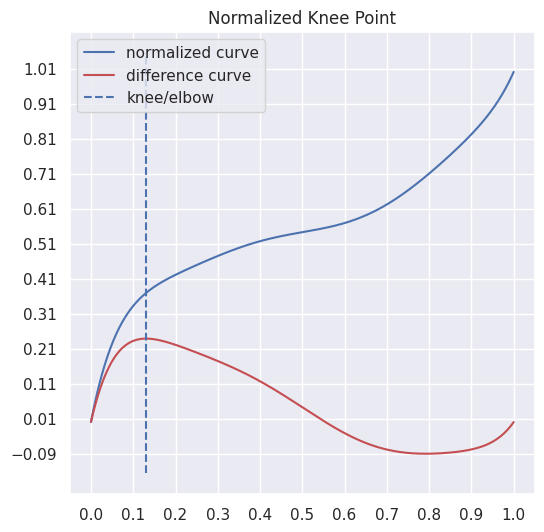

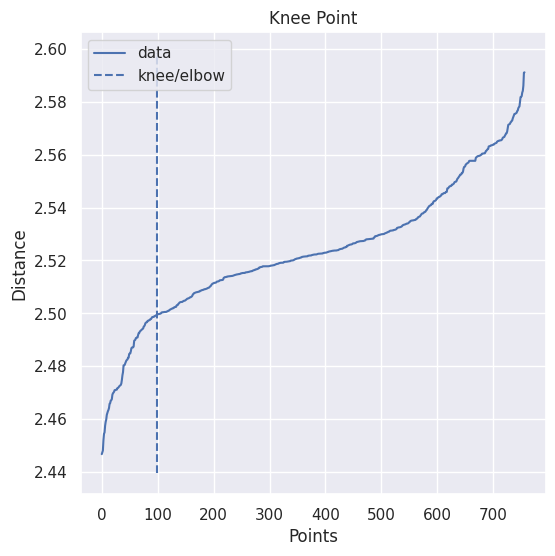

In [20]:
#### DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

try:
    from kneed import KneeLocator
except ImportError as error:
    !pip install kneed[plot];
    from kneed import KneeLocator

# WIP
# Since we’re talking in radians now, we need to convert the epsilon input into radian measure.
# See:
# - https://towardsdatascience.com/lets-do-spatial-clustering-with-dbscan-c3dbfd9fc4d2
# - https://stats.stackexchange.com/questions/218530/applying-dbscan-to-a-huge-gis-dataset-with-a-haversine-distance-metric
# - https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers
KMS_PER_RADIAN = 6371.0088

dbscan_places_to_visit = get_user_radius_df()

nearest_neighbors = NearestNeighbors(n_neighbors = u_nb_jour, metric ="haversine") # 5 parce que pourquoi pas ?

radians_coords = np.radians([x for x in zip(dbscan_places_to_visit["latitude"], dbscan_places_to_visit["longitude"])])
neighbors = nearest_neighbors.fit(radians_coords)
distances, indices = neighbors.kneighbors(dbscan_places_to_visit[["latitude", "longitude"]])
distances = np.sort(distances[:,3], axis=0)
# Find the elbow / knee
i = np.arange(len(distances))
kneedle = KneeLocator(
    i,
    distances,
    S=1,
    curve='concave',
    online=True,
    direction='increasing',
    interp_method='polynomial',
    polynomial_degree=7
)

PLOT_KNEE = True

if PLOT_KNEE:
    fig = plt.figure(figsize=(5, 5))
    kneedle.plot_knee_normalized()
    kneedle.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print(f"distances[knee] :{distances[kneedle.knee]}")

print(f"knee: {kneedle.knee}")

eps = distances[kneedle.knee]

def haversine_dbscan(epsilon, min_samples, latitudes, longitudes):
    epsilon_for_haversine = epsilon / KMS_PER_RADIAN
    print(epsilon_for_haversine)

    # The ball tree algorithm is used to speed up the algorithm run time

    # The haversine calculation requires co-ordinate pairs to be specified in radians and not degrees.
    # We do this via a quick call to one of my favourite packages — numpy . We need to make sure that the order
    # of the co-ordinate pairs is correct, as sklearn expects latitude first.
    # (PLUS HAUT)
    # app_df["coord"] = list(zip(app_df["Latitude"], app_df["Longitude"])) # Coord tupples

    dbscan = DBSCAN(
        eps = epsilon_for_haversine,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine'
    )


    dbscan.fit(np.radians([x for x in zip(latitudes,longitudes)]))

    return dbscan.labels_

labels = haversine_dbscan(
    epsilon=eps,
    min_samples=2,
    latitudes=dbscan_places_to_visit['latitude'],
    longitudes=dbscan_places_to_visit["longitude"]
)

dbscan_places_to_visit['Cluster'] = labels
dbscan_places_to_visit = dbscan_places_to_visit[dbscan_places_to_visit['Cluster'] != -1] # remove outliers
dbscan_places_to_visit['Jour'] = dbscan_places_to_visit['Cluster'] + 1

dbscan_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(dbscan_places_to_visit, map_to_plot=dbscan_map)

dbscan_map

In [1]:
try:
    import hdbscan
except ImportError as error:
    !pip install hdbscan;
    import hdbscan

hdbscan_places_to_visit = get_user_radius_df()

radians_coords = np.radians(hdbscan_places_to_visit[['latitude', 'longitude']].values) # ¯\_( ͡° ͜ʖ ͡°)_/¯

hdbscan_clf = hdbscan.HDBSCAN(min_cluster_size=2, max_cluster_size=8, metric='haversine')
predictions = hdbscan_clf.fit_predict(radians_coords)

hdbscan_clustered = pd.concat([hdbscan_places_to_visit.reset_index(),  pd.DataFrame({'Cluster':predictions})],  axis=1)
hdbscan_clustered = hdbscan_clustered[hdbscan_clustered['Cluster'] != -1]
hdbscan_clustered['Jour'] = hdbscan_clustered['Cluster'] + 1

hdbscan_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])

plot_markers(hdbscan_clustered, map_to_plot=hdbscan_map)

hdbscan_map

NameError: name 'get_user_radius_df' is not defined

In [9]:
final_to_visit = get_user_radius_df()
lat_lon = final_to_visit[['longitude','latitude']].values

final_model = BisectingKMeans(n_clusters=u_nb_jour, init='k-means++', random_state=123, bisecting_strategy='largest_cluster').fit(lat_lon)
final_model_clusters = final_model.labels_

final_to_visit['Cluster'] = pd.Series(final_model_clusters, index=final_to_visit.index)
final_to_visit['Jour']  = final_to_visit['Cluster'] + 1

final_map = folium.Map(location = u_start_point , tiles = "OpenStreetMap", zoom_start = ZOOM_LVL[u_moyen_mobilite])
plot_markers(final_to_visit, map_to_plot=final_map)

for jour_num in range(u_nb_jour):
    df_day_to_plot = final_to_visit[final_to_visit['Jour'] == jour_num + 1]
    color = FOLIUM_COLORS[jour_num]
    plot_day_path(df_day_to_plot, map_to_plot=final_map, color=color)

final_map